<a href="https://colab.research.google.com/github/LeoFades/COS30082_Cross_Domain_Plant_Species_Identification/blob/main/alt_improved_dinov2%2Bproto%2Bdann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Set seed for reproducible run

In [ ]:
# =============================================================================
# REPRODUCIBILITY SETUP (ADD AT TOP OF NOTEBOOK)
# =============================================================================

import random
import numpy as np
import torch
import os

def set_seed(seed=42):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"✅ Random seed set to {seed} for reproducibility")

# CRITICAL: Run this FIRST!
set_seed(42)

✅ Random seed set to 42 for reproducibility


# Install Libraries

In [ ]:
!pip install torch torchvision timm pandas numpy matplotlib seaborn scikit-learn tqdm

print("\n✅ Dependencies installed")


✅ Dependencies installed


# Import Libraries

In [ ]:
import os, zipfile, time, math
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
import timm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

print("✅ Libraries imported")

✅ Libraries imported


# Define Paths

In [ ]:
base_dir = '/content/drive/MyDrive/AML_Group_Project'

# === Extract Dataset from Drive ===
zip_path = os.path.join(base_dir, 'AML_project_herbarium_dataset.zip')
extract_dir = '/content/AML_project_herbarium_dataset'

start = time.time()
if not os.path.exists(extract_dir):
    print(f"Extracting {os.path.basename(zip_path)} ...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Extraction complete in {(time.time() - start):.1f}s")
else:
    print("✅ Dataset already extracted")

train_txt = os.path.join(extract_dir, 'list/train.txt')
test_txt  = os.path.join(extract_dir, 'list/test.txt')
groundtruth_txt = os.path.join(extract_dir, 'list/groundtruth.txt')
paired_file = os.path.join(extract_dir, 'list/class_with_pairs.txt')
unpaired_file = os.path.join(extract_dir, 'list/class_without_pairs.txt')
root_dir = extract_dir

# Create a directory in Drive to store results
SAVE_DIR = os.path.join(base_dir, "Approach_New/Phyllis/models_alt")
os.makedirs(SAVE_DIR, exist_ok=True)
print("✅ Dataset paths defined")

Extracting AML_project_herbarium_dataset.zip ...
✅ Extraction complete in 23.8s
✅ Dataset paths defined


Sanity Checking to see if all paths exist

In [ ]:
# Check if paths exist
paths_name = ['train_txt', 'test_txt', 'groundtruth_txt', 'paired_file', 'unpaired_file', 'root_dir']
paths = [train_txt, test_txt, groundtruth_txt, paired_file, unpaired_file, root_dir]
print("Checking paths...")
for path_name, path in zip(paths_name, paths):
    if not os.path.exists(path):
        print(f"❌ {path_name} does not exist: {path}")
    else:
        print(f"✅ {path_name} exists: {path}")

Checking paths...
✅ train_txt exists: /content/AML_project_herbarium_dataset/list/train.txt
✅ test_txt exists: /content/AML_project_herbarium_dataset/list/test.txt
✅ groundtruth_txt exists: /content/AML_project_herbarium_dataset/list/groundtruth.txt
✅ paired_file exists: /content/AML_project_herbarium_dataset/list/class_with_pairs.txt
✅ unpaired_file exists: /content/AML_project_herbarium_dataset/list/class_without_pairs.txt
✅ root_dir exists: /content/AML_project_herbarium_dataset


# Define Hyperparameters

In [1]:
IMG_SIZE = 518
BATCH_EXTRACT = 4        # Reduced for feature extraction to mitigate OOM
BATCH_SIZE_TRAIN = 64     # for head training on precomputed features (no GPU pressure)
NUM_WORKERS = 2
EPOCHS = 12
LR = 1e-3                 # head can use larger lr
WEIGHT_DECAY = 1e-5
PROJ_DIM = 512
CLASSIFIER_HID = 512 #
PROTO_WEIGHT = 3.0 # Prototypical network loss weightage
ADV_WEIGHT = 1.0 # Adverserial loss weightage
print("\n Hyperparameters set")

# Detect if GPU is available (for faster training)
if torch.cuda.is_available():
    print(f" CUDA is available. GPU: {torch.cuda.get_device_name(0)}")
else:
    print(" CUDA not available. Training will be slow on CPU.")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


✅ CUDA is available. GPU: Tesla T4
Using device: cuda

✅ Hyperparameters set


In [ ]:
CROP = IMG_SIZE # Define CROP using IMG_SIZE

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Prepare Plant Dataset

Helper function to assign herbarium or field class to training images.

In [ ]:
def detect_domain_from_path(path_str):
    s = path_str.lower()
    # common dataset layout: ".../train/Herbarium/..." or ".../train/photo/..."
    if 'herbarium' in s:
        return 0
    if 'photo' in s:
        return 1
    if 'test' in s:
        return 1
    # fallback heuristics: filenames with 'IMG' etc -> field? This is heuristic
    # Use presence in groundtruth/test lists to determine domain: not here.
    # As a last resort, assume herbarium if filename contains 'sheet' or endswith '.jpg' -> unknown
    return 0

Loading training and testing sets as well as assigning respective classes

In [ ]:
# -----------------------
# Load train/test lists
# -----------------------
train_df = pd.read_csv(train_txt, sep=' ', names=['path', 'label'])
gt_df = pd.read_csv(groundtruth_txt, sep=' ', names=['path', 'label'])
test_df = pd.read_csv(test_txt, names=['path'])
test_df = pd.merge(test_df, gt_df, on='path', how='left')

# Remap labels to contiguous indices (0..N-1)
unique_labels = sorted(train_df['label'].unique())
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
train_df['label'] = train_df['label'].map(label_to_idx)
test_df['label'] = test_df['label'].map(label_to_idx)

NUM_CLASSES = len(unique_labels)
print(f"Total species used: {NUM_CLASSES}")

Total species used: 100


In [ ]:
# Read paired/unpaired class lists (they contain original class ids; map to index)
def read_class_list(path):
    if not os.path.exists(path):
        return []
    out = []
    with open(path) as f:
        for line in f:
            line=line.strip()
            if not line: continue
            try:
                out.append(int(line))
            except:
                pass
    return out

paired_raw = read_class_list(paired_file)
unpaired_raw = read_class_list(unpaired_file)
paired_classes = [label_to_idx[c] for c in paired_raw if c in label_to_idx]
unpaired_classes = [label_to_idx[c] for c in unpaired_raw if c in label_to_idx]

Creating the actual dataset for training and evaluation

In [ ]:
class ImageListDataset(Dataset):
    def __init__(self, df, root, transform):
        self.root = root
        self.transform = transform
        self.paths = df['path'].tolist()
        self.labels = df['label'].tolist()
        # compute domain per sample
        self.domains = [detect_domain_from_path(p) for p in self.paths]

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        img_path = os.path.join(self.root, p)
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        label = int(self.labels[idx])
        domain = int(self.domains[idx])
        return img, label, domain, p  # return path for debugging

train_img_ds = ImageListDataset(train_df, extract_dir, eval_transform)  # use eval_transform to get stable feats
test_img_ds  = ImageListDataset(test_df, extract_dir, eval_transform)

train_img_loader = DataLoader(train_img_ds, batch_size=BATCH_EXTRACT, shuffle=False, num_workers=NUM_WORKERS)
test_img_loader  = DataLoader(test_img_ds,  batch_size=BATCH_EXTRACT, shuffle=False, num_workers=NUM_WORKERS)

# Check domain distribution in original dataset
all_train_domains = []
for imgs, labels, domains, paths in train_img_loader:
    all_train_domains.extend(domains.tolist())

print(f"Original train set - Herbarium: {all_train_domains.count(0)}, Field: {all_train_domains.count(1)}")

print("Train samples:", len(train_img_ds))
print("Test samples :", len(test_img_ds))

Original train set - Herbarium: 3700, Field: 1044
Train samples: 4744
Test samples : 207


Initialising finetuned DINOv2 model

In [ ]:
import argparse
import torch.serialization
torch.serialization.add_safe_globals([argparse.Namespace])

print("Loading fine-tuned backbone from Kaggle...")
# Download model
import kagglehub
model_path = kagglehub.model_download(
    'juliostat/dinov2_patch14_reg4_onlyclassifier_then_all/PyTorch/default/3'
)

weights_path = f"{model_path}/model_best.pth.tar"
checkpoint = torch.load(weights_path, map_location=DEVICE)

state_dict = checkpoint["state_dict"] if "state_dict" in checkpoint else checkpoint

# --- IMPORTANT: Load using TIMM ---
import timm

BACKBONE_NAME = "vit_base_patch14_reg4_dinov2"

backbone = timm.create_model(BACKBONE_NAME, pretrained=False)

# Remove classifier head
try:
    backbone.reset_classifier(0)
except:
    pass

backbone.load_state_dict(state_dict, strict=False)

print("✅ Fine-tuned DINOv2 (timm version) loaded correctly")

backbone = backbone.to(DEVICE)
backbone.eval()

for p in backbone.parameters():
    p.requires_grad = False

feat_dim = backbone.num_features
print("Backbone feat dim:", feat_dim)


feat_dim = backbone.num_features
print("Backbone feat dim:", feat_dim)

# Paths to save precomputed features
os.makedirs(os.path.join(SAVE_DIR, "train"), exist_ok=True)
os.makedirs(os.path.join(SAVE_DIR, "test"), exist_ok=True)

train_feats_path = os.path.join(SAVE_DIR, "train/train_backbone_feats.pt")
train_labels_path = os.path.join(SAVE_DIR, "train/train_labels.pt")
train_domains_path = os.path.join(SAVE_DIR, "train/train_domains.pt")
train_paths_path = os.path.join(SAVE_DIR, "train/train_paths.npy")

test_feats_path = os.path.join(SAVE_DIR, "test/test_backbone_feats.pt")
test_labels_path = os.path.join(SAVE_DIR, "test/test_labels.pt")
test_domains_path = os.path.join(SAVE_DIR, "test/test_domains.pt")
test_paths_path = os.path.join(SAVE_DIR, "test/test_paths.npy")

Loading fine-tuned backbone from Kaggle...
✅ Fine-tuned DINOv2 (timm version) loaded correctly
Backbone feat dim: 768
Backbone feat dim: 768


In [ ]:
# If features not saved yet -> extract once
if not (os.path.exists(train_feats_path) and os.path.exists(test_feats_path)):
    torch.cuda.empty_cache()
    print("Extracting backbone features for training set (this runs once)...")
    all_feats = []
    all_labels = []
    all_domains = []
    all_paths = []
    with torch.no_grad():
        for imgs, labels, domains, paths in tqdm(train_img_loader, desc="Extract train feats"):
            imgs = imgs.to(DEVICE)
            feats = backbone(imgs)        # (B, feat_dim)
            feats = feats.detach().cpu()
            all_feats.append(feats)
            all_labels.append(torch.tensor(labels))
            all_domains.append(torch.tensor(domains))
            all_paths.extend(paths)
    train_feats = torch.cat(all_feats)               # (N_train, feat_dim)
    train_labels = torch.cat(all_labels).long()      # (N_train,)
    train_domains = torch.cat(all_domains).long()    # (N_train,)
    torch.save(train_feats, train_feats_path)
    torch.save(train_labels, train_labels_path)
    torch.save(train_domains, train_domains_path)
    np.save(train_paths_path, np.array(all_paths))
    print("Saved train backbone features to:", train_feats_path, train_labels_path, train_domains_path)

    print("Extracting backbone features for test set...")
    all_feats = []
    all_labels = []
    all_domains = []
    all_paths = []
    with torch.no_grad():
        for imgs, labels, domains, paths in tqdm(test_img_loader, desc="Extract test feats"):
            imgs = imgs.to(DEVICE)
            feats = backbone(imgs)
            feats = feats.detach().cpu()
            all_feats.append(feats)
            all_labels.append(torch.tensor(labels))
            all_domains.append(torch.tensor(domains))
            all_paths.extend(paths)
    test_feats = torch.cat(all_feats)
    test_labels = torch.cat(all_labels).long()
    test_domains = torch.cat(all_domains).long()
    torch.save(test_feats, test_feats_path)
    torch.save(test_labels, test_labels_path)
    torch.save(test_domains, test_domains_path)
    np.save(test_paths_path, np.array(all_paths))
    print("Saved test backbone features to:", test_feats_path, test_labels_path, test_domains_path)
else:
    print("Precomputed backbone features found. Loading them...")



Precomputed backbone features found. Loading them...


Sanity Checking for image domains

In [ ]:
# load features (ensure they exist)
train_feats = torch.load(train_feats_path)    # CPU tensor
train_labels = torch.load(train_labels_path)
train_domains = torch.load(train_domains_path)
train_paths = np.load(train_paths_path, allow_pickle=True)

test_feats = torch.load(test_feats_path)
test_labels = torch.load(test_labels_path)
test_domains = torch.load(test_domains_path)
test_paths = np.load(test_paths_path, allow_pickle=True)

# ADD THIS VERIFICATION:
print("\n=== DOMAIN VERIFICATION ===")
print(f"Train domains - Herbarium: {(train_domains == 0).sum()}, Field: {(train_domains == 1).sum()}")
print(f"Test domains - Herbarium: {(test_domains == 0).sum()}, Field: {(test_domains == 1).sum()}")


# === COMPREHENSIVE VERIFICATION ===
print("\n" + "="*60)
print("DOMAIN DISTRIBUTION CHECK")
print("="*60)

# 1. Check saved domain distributions
herb_train = (train_domains == 0).sum().item()
field_train = (train_domains == 1).sum().item()
herb_test = (test_domains == 0).sum().item()
field_test = (test_domains == 1).sum().item()

print(f"Training set: {herb_train} herbarium, {field_train} field")
print(f"Test set: {herb_test} herbarium, {field_test} field")

if field_train == 0:
    print("❌ ERROR: No field images in training! Features NOT re-extracted!")
    print("   Delete these files and re-run:")
    print(f"   - {train_feats_path}")
    print(f"   - {train_domains_path}")
else:
    print(f"✅ Training has {field_train} field images")

# 2. Sample paths
print(f"\nSample paths with domains:")
for i in [0, 100, 500, 1000, 2000]:
    if i < len(train_paths):
        domain_str = "HERB" if train_domains[i] == 0 else "FIELD"
        print(f"  [{domain_str}] {train_paths[i]}")

print("="*60 + "\n")



print("Train feats shape:", train_feats.shape)
print("Test feats shape:", test_feats.shape)


=== DOMAIN VERIFICATION ===
Train domains - Herbarium: 3700, Field: 1044
Test domains - Herbarium: 0, Field: 207

DOMAIN DISTRIBUTION CHECK
Training set: 3700 herbarium, 1044 field
Test set: 0 herbarium, 207 field
✅ Training has 1044 field images

Sample paths with domains:
  [FIELD] train/photo/106461/154340.jpg
  [FIELD] train/photo/127151/265055.jpg
  [FIELD] train/photo/13370/16490.jpg
  [HERB] train/herbarium/174017/245186.jpg
  [HERB] train/herbarium/110432/293664.jpg

Train feats shape: torch.Size([4744, 768])
Test feats shape: torch.Size([207, 768])


In [ ]:
# -----------------------
# Dataset for training head (uses precomputed backbone feats)
# -----------------------
class FeatureDataset(Dataset):
    def __init__(self, feats_tensor, labels_tensor, domains_tensor, paths_array):
        # expects CPU tensors
        self.feats = feats_tensor.float()
        self.labels = labels_tensor.long()
        self.domains = domains_tensor.long()
        self.paths = list(paths_array)

    def __len__(self): return self.feats.size(0)

    def __getitem__(self, idx):
        return self.feats[idx], int(self.labels[idx]), int(self.domains[idx]), self.paths[idx]

train_feat_ds = FeatureDataset(train_feats, train_labels, train_domains, train_paths)
test_feat_ds  = FeatureDataset(test_feats, test_labels, test_domains, test_paths)

In [ ]:
# -----------------------
# Class-balanced loss weights
# -----------------------
class_counts = torch.bincount(train_labels)
class_weights_tensor = 1.0 / torch.sqrt(class_counts.float())
class_weights_tensor = class_weights_tensor / class_weights_tensor.sum() * len(class_weights_tensor)

# -----------------------
# Balanced domain sampler (ensures both domains in batches for CORAL)
# -----------------------
from torch.utils.data import Sampler

class BalancedDomainSampler(Sampler):
    def __init__(self, domains_tensor, batch_size):
        self.batch_size = batch_size
        self.herb_indices = torch.where(domains_tensor == 0)[0].tolist()
        self.field_indices = torch.where(domains_tensor == 1)[0].tolist()

    def __iter__(self):
        # Shuffle both domain lists
        herb_shuffled = torch.randperm(len(self.herb_indices)).tolist()
        field_shuffled = torch.randperm(len(self.field_indices)).tolist()

        # Interleave to mix domains in each batch
        mixed = []
        max_len = max(len(herb_shuffled), len(field_shuffled))
        for i in range(max_len):
            if i < len(herb_shuffled):
                mixed.append(self.herb_indices[herb_shuffled[i]])
            if i < len(field_shuffled):
                mixed.append(self.field_indices[field_shuffled[i]])

        return iter(mixed)

    def __len__(self):
        return len(self.herb_indices) + len(self.field_indices)

domain_sampler = BalancedDomainSampler(train_domains, BATCH_SIZE_TRAIN)
train_loader = DataLoader(train_feat_ds, batch_size=BATCH_SIZE_TRAIN, sampler=domain_sampler, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_feat_ds, batch_size=BATCH_SIZE_TRAIN, shuffle=False, num_workers=NUM_WORKERS)

print("Train batches:", len(train_loader))
print("Test batches :", len(test_loader))
print(f"Herbarium samples: {(train_domains == 0).sum()}, Field samples: {(train_domains == 1).sum()}")

Train batches: 75
Test batches : 4
Herbarium samples: 3700, Field samples: 1044


In [ ]:
# -----------------------
# Focal Loss for hard examples
# -----------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight

    def forward(self, logits, labels):
        ce_loss = F.cross_entropy(logits, labels, reduction='none', weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# -----------------------
# Head model: projection + classifier only (no backbone)
# -----------------------
class HeadClassifier(nn.Module):
    def __init__(self, feat_dim, proj_dim=512, hid=512, num_classes=NUM_CLASSES):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(feat_dim, hid),
            nn.ReLU(),
            nn.Linear(hid, proj_dim)
        )
        self.classifier = nn.Linear(proj_dim, num_classes)

    def forward(self, feats, return_unnormalized=False):   # ← Add parameter
        z_raw = self.proj(feats)  # Raw projection (for CORAL)
        z = F.normalize(z_raw, dim=-1)  # Normalized (for prototypes/classifier)
        logits = self.classifier(z)

        if return_unnormalized:
            return z, logits, z_raw  # ← Return raw embeddings too
        return z, logits

head = HeadClassifier(feat_dim, proj_dim=PROJ_DIM, hid=CLASSIFIER_HID, num_classes=NUM_CLASSES).to(DEVICE)

optimizer = torch.optim.AdamW(head.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
ce_loss = FocalLoss(gamma=2.0, weight=class_weights_tensor.to(DEVICE))

# -----------------------
# Domain Discriminator for DANN
# -----------------------
class DomainDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.net(x)

# Create discriminator
domain_disc = DomainDiscriminator(PROJ_DIM).to(DEVICE)
disc_optimizer = torch.optim.AdamW(domain_disc.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

print(f"Domain Discriminator parameters: {sum(p.numel() for p in domain_disc.parameters()):,}")

class GradientReversalLayer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.alpha * grad_output, None

def grad_reverse(x, alpha=1.0):
    return GradientReversalLayer.apply(x, alpha)

Domain Discriminator parameters: 198,401


In [ ]:
# -----------------------
# Loss helpers: prototypes, proto loss, coral
# -----------------------
def compute_prototypes_head(model, loader):
    """Compute domain-invariant prototypes."""
    model.eval()
    accum = [[[], []] for _ in range(NUM_CLASSES)]

    with torch.no_grad():
        for feats, labels, domains, paths in loader:
            feats = feats.to(DEVICE)
            labels = labels.to(DEVICE)
            domains = domains.to(DEVICE)

            z, _ = model(feats)  # This gets normalized z (no return_unnormalized)

            z = z.detach().cpu()
            labels = labels.cpu().numpy()
            domains = domains.cpu().numpy()

            for i, (lab, dom) in enumerate(zip(labels, domains)):
                accum[lab][dom].append(z[i].numpy())

    prot = torch.zeros(NUM_CLASSES, PROJ_DIM, dtype=torch.float32)
    for c in range(NUM_CLASSES):
        herb_samples = accum[c][0]
        field_samples = accum[c][1]

        parts = []
        if len(herb_samples) > 0:
            parts.append(np.mean(herb_samples, axis=0))
        if len(field_samples) > 0:
            parts.append(np.mean(field_samples, axis=0))

        if len(parts) > 0:
            prot[c] = torch.tensor(np.mean(parts, axis=0), dtype=torch.float32)
        else:
            prot[c] = torch.zeros(PROJ_DIM)

    prot = F.normalize(prot, dim=1)  # Ensure prototypes are normalized
    return prot.to(DEVICE)

def proto_loss_for_batch(z_batch, labels_batch, prototypes):
    sims = z_batch @ prototypes.t()
    correct = sims[range(sims.size(0)), labels_batch]
    return 1.0 - torch.mean(correct)  # Loss = 0 when similarity = 1.0

In [ ]:
for c in unpaired_classes:
    herb = ((train_labels == c) & (train_domains == 0)).sum()
    field = ((train_labels == c) & (train_domains == 1)).sum()
    print(f"Class {c}: {herb} herb, {field} field")

Class 17: 50 herb, 0 field
Class 19: 50 herb, 0 field
Class 23: 50 herb, 0 field
Class 24: 50 herb, 0 field
Class 25: 38 herb, 0 field
Class 27: 50 herb, 0 field
Class 28: 50 herb, 0 field
Class 29: 50 herb, 0 field
Class 30: 50 herb, 0 field
Class 33: 50 herb, 0 field
Class 35: 50 herb, 0 field
Class 39: 50 herb, 0 field
Class 4: 50 herb, 0 field
Class 5: 50 herb, 0 field
Class 45: 40 herb, 0 field
Class 49: 50 herb, 0 field
Class 50: 50 herb, 0 field
Class 54: 50 herb, 0 field
Class 55: 50 herb, 0 field
Class 9: 50 herb, 0 field
Class 57: 50 herb, 0 field
Class 58: 50 herb, 0 field
Class 60: 46 herb, 0 field
Class 61: 22 herb, 0 field
Class 10: 50 herb, 0 field
Class 65: 50 herb, 0 field
Class 12: 50 herb, 0 field
Class 74: 50 herb, 0 field
Class 75: 50 herb, 0 field
Class 76: 50 herb, 0 field
Class 66: 22 herb, 0 field
Class 80: 25 herb, 0 field
Class 82: 25 herb, 0 field
Class 85: 31 herb, 0 field
Class 21: 25 herb, 0 field
Class 0: 32 herb, 0 field
Class 42: 40 herb, 0 field
Class

In [ ]:

# subset metrics for paired/unpaired
def subset_metrics(y_true, y_pred, y_top5, mask_classes):
    mask = np.isin(y_true, mask_classes)
    if mask.sum() == 0: return (np.nan, np.nan, np.nan)
    y_t = y_true[mask]
    y_p = y_pred[mask]
    y5 = y_top5[mask]
    top1 = np.mean(y_t == y_p)
    top5 = np.mean([y_t[i] in y5[i] for i in range(len(y_t))])
    accs = []
    for c in mask_classes:
        idxs = np.where(y_t == c)[0]
        if len(idxs)>0: accs.append(np.mean(y_p[idxs] == y_t[idxs]))
    avg_cls = np.mean(accs) if accs else np.nan
    return top1, top5, avg_cls
domain_disc = DomainDiscriminator(PROJ_DIM).to(DEVICE)
disc_optimizer = torch.optim.AdamW(domain_disc.parameters(), lr=LR * 0.5, weight_decay=WEIGHT_DECAY)

# Hyperparameters
PROTO_WEIGHT = 0.5
ADV_WEIGHT = 0.5  # Start moderate with gradient reversal

# -----------------------
# Training loop with proper gradient reversal
# -----------------------
best_top1 = 0.0
best_state = None

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS} - computing prototypes and training head")
    torch.cuda.empty_cache()
    prototypes = compute_prototypes_head(head, DataLoader(train_feat_ds, batch_size=256, shuffle=False, num_workers=NUM_WORKERS))

    head.train()
    domain_disc.train()

    running_loss = running_ce = running_proto = running_adv = running_disc = 0.0
    n_samples = 0
    disc_correct = 0
    disc_total = 0

    # Dynamic adversarial weight schedule
    if epoch <= 2:
        current_adv_weight = 0.0
        print("  Phase 1: Warmup - No adversarial loss")
    elif epoch <= 6:
        current_adv_weight = 0.5
        print(f"  Phase 2: Moderate adversarial (weight={current_adv_weight})")
    else:
        current_adv_weight = 1.0
        print(f"  Phase 3: Full adversarial (weight={current_adv_weight})")

    for feats, labels, domains, paths in tqdm(train_loader, desc="Train head"):
        feats = feats.to(DEVICE)
        labels = labels.to(DEVICE)
        domains = domains.to(DEVICE)

        z, logits, z_raw = head(feats, return_unnormalized=True)

        # ========================================
        # 1. Train Domain Discriminator
        # ========================================
        domain_pred = domain_disc(z_raw.detach())
        domain_labels = domains.float().unsqueeze(1)
        disc_loss = F.binary_cross_entropy_with_logits(domain_pred, domain_labels)

        # Only train discriminator if adversarial is active
        if current_adv_weight > 0:
            disc_optimizer.zero_grad()
            disc_loss.backward()
            disc_optimizer.step()

        disc_pred_binary = (torch.sigmoid(domain_pred) > 0.5).float()
        disc_correct += (disc_pred_binary == domain_labels).sum().item()
        disc_total += len(domain_labels)

        # ========================================
        # 2. Train Head
        # ========================================
        loss_ce = ce_loss(logits, labels)
        loss_proto = proto_loss_for_batch(z, labels, prototypes)

        # Adversarial loss with gradient reversal
        if current_adv_weight > 0:
            z_reversed = grad_reverse(z_raw, alpha=current_adv_weight)
            domain_pred_adv = domain_disc(z_reversed)
            adv_loss = F.binary_cross_entropy_with_logits(domain_pred_adv, domain_labels)
        else:
            adv_loss = torch.tensor(0.0, device=DEVICE)

        # Total loss
        loss = loss_ce + PROTO_WEIGHT * loss_proto + adv_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        b = feats.size(0)
        n_samples += b
        running_loss += loss.item() * b
        running_ce += loss_ce.item() * b
        running_proto += loss_proto.item() * b
        running_adv += adv_loss.item() * b if current_adv_weight > 0 else 0
        running_disc += disc_loss.item() * b

        if n_samples == b:
            print(f"  First batch - CE: {loss_ce.item():.4f}, Proto: {loss_proto.item():.4f}, Adv: {adv_loss.item():.4f}, Disc: {disc_loss.item():.4f}")

    disc_acc = disc_correct / disc_total
    print(f"Epoch {epoch} train loss: {running_loss/n_samples:.4f} "
          f"(CE={running_ce/n_samples:.4f}, Proto={running_proto/n_samples:.4f}, "
          f"Adv={running_adv/n_samples:.4f}, DiscLoss={running_disc/n_samples:.4f})")
    print(f"  Domain Discriminator Accuracy: {disc_acc*100:.2f}% (target: 50-60%)")

    # ========================================
    # Evaluation
    # ========================================
    head.eval()
    domain_disc.eval()
    torch.cuda.empty_cache()

    # Recompute prototypes
    prototypes = compute_prototypes_head(head, DataLoader(train_feat_ds, batch_size=256, shuffle=False, num_workers=NUM_WORKERS))

    # Collect predictions
    all_z = []
    all_labels = []
    all_logits = []

    with torch.no_grad():
        for feats, labels, domains, paths in tqdm(test_loader, desc="Eval head"):
            feats = feats.to(DEVICE)
            labels = labels.to(DEVICE)
            z, logits = head(feats)
            all_z.append(z.cpu())
            all_labels.append(labels.cpu())
            all_logits.append(logits.cpu())

    test_z = torch.cat(all_z)
    test_labels_arr = torch.cat(all_labels).numpy()
    test_logits = torch.cat(all_logits)

    # Prototype-based prediction
    sims = test_z @ prototypes.cpu().t()
    proto_pred = sims.argmax(dim=1).numpy()
    proto_top5 = torch.topk(sims, k=5, dim=1).indices.numpy()

    # Classifier-based prediction
    classifier_pred = test_logits.argmax(dim=1).numpy()
    classifier_top5 = torch.topk(test_logits, k=5, dim=1).indices.numpy()

    # Compute accuracies
    proto_top1 = (proto_pred == test_labels_arr).mean()
    classifier_top1 = (classifier_pred == test_labels_arr).mean()

    print(f"Epoch {epoch} Eval - Prototype: {proto_top1*100:.2f}%, Classifier: {classifier_top1*100:.2f}%")

    # Use classifier for best model selection
    if classifier_top1 > best_top1:
        best_top1 = classifier_top1
        best_state = {
            'head_state': head.state_dict(),
            'disc_state': domain_disc.state_dict(),
            'prototypes': prototypes.cpu(),
            'label_to_idx': label_to_idx,
            'epoch': epoch
        }
        torch.save(best_state, os.path.join(SAVE_DIR, "best_head_dann.pth"))
        print("  ✅ Saved best checkpoint!")


Epoch 1/12 - computing prototypes and training head
  Phase 1: Warmup - No adversarial loss


Train head:  16%|█▌        | 12/75 [00:01<00:06,  9.39it/s]

  First batch - CE: 4.4440, Proto: 0.2391, Adv: 0.0000, Disc: 0.7139


Train head: 100%|██████████| 75/75 [00:02<00:00, 30.64it/s]

Epoch 1 train loss: 4.2863 (CE=4.1791, Proto=0.2143, Adv=0.0000, DiscLoss=0.7118)
  Domain Discriminator Accuracy: 52.55% (target: 50-60%)



Eval head: 100%|██████████| 4/4 [00:00<00:00, 31.33it/s]


Epoch 1 Eval - Prototype: 69.08%, Classifier: 60.87%
  ✅ Saved best checkpoint!

Epoch 2/12 - computing prototypes and training head
  Phase 1: Warmup - No adversarial loss


Train head:   4%|▍         | 3/75 [00:00<00:02, 29.69it/s]

  First batch - CE: 3.7741, Proto: 0.0870, Adv: 0.0000, Disc: 0.7006


Train head: 100%|██████████| 75/75 [00:00<00:00, 115.13it/s]

Epoch 2 train loss: 3.4087 (CE=3.3156, Proto=0.1863, Adv=0.0000, DiscLoss=0.7001)
  Domain Discriminator Accuracy: 53.52% (target: 50-60%)



Eval head: 100%|██████████| 4/4 [00:00<00:00, 30.94it/s]

Epoch 2 Eval - Prototype: 74.40%, Classifier: 70.53%
  ✅ Saved best checkpoint!

Epoch 3/12 - computing prototypes and training head


  Phase 2: Moderate adversarial (weight=0.5)


Train head:   1%|▏         | 1/75 [00:00<00:07,  9.33it/s]

  First batch - CE: 2.6750, Proto: 0.0484, Adv: 0.6520, Disc: 0.6944


Train head: 100%|██████████| 75/75 [00:00<00:00, 88.69it/s] 

Epoch 3 train loss: 3.1086 (CE=2.4790, Proto=0.1318, Adv=0.5637, DiscLoss=0.5835)
  Domain Discriminator Accuracy: 66.29% (target: 50-60%)



Eval head: 100%|██████████| 4/4 [00:00<00:00, 33.62it/s]

Epoch 3 Eval - Prototype: 74.40%, Classifier: 73.43%
  ✅ Saved best checkpoint!

Epoch 4/12 - computing prototypes and training head


  Phase 2: Moderate adversarial (weight=0.5)


Train head:   1%|▏         | 1/75 [00:00<00:08,  8.54it/s]

  First batch - CE: 2.1576, Proto: 0.0603, Adv: 1.2093, Disc: 1.1566


Train head: 100%|██████████| 75/75 [00:00<00:00, 88.14it/s] 

Epoch 4 train loss: 2.3008 (CE=1.6505, Proto=0.0898, Adv=0.6054, DiscLoss=0.6215)
  Domain Discriminator Accuracy: 73.57% (target: 50-60%)



Eval head: 100%|██████████| 4/4 [00:00<00:00, 32.09it/s]

Epoch 4 Eval - Prototype: 79.23%, Classifier: 77.78%
  ✅ Saved best checkpoint!

Epoch 5/12 - computing prototypes and training head


  Phase 2: Moderate adversarial (weight=0.5)


Train head:   4%|▍         | 3/75 [00:00<00:02, 28.05it/s]

  First batch - CE: 1.2576, Proto: 0.0446, Adv: 1.0392, Disc: 1.0523


Train head: 100%|██████████| 75/75 [00:00<00:00, 86.09it/s]

Epoch 5 train loss: 1.6157 (CE=1.0081, Proto=0.0641, Adv=0.5755, DiscLoss=0.5859)
  Domain Discriminator Accuracy: 76.33% (target: 50-60%)



Eval head: 100%|██████████| 4/4 [00:00<00:00, 33.78it/s]

Epoch 5 Eval - Prototype: 80.19%, Classifier: 78.74%
  ✅ Saved best checkpoint!

Epoch 6/12 - computing prototypes and training head


  Phase 2: Moderate adversarial (weight=0.5)


Train head:   3%|▎         | 2/75 [00:00<00:04, 17.99it/s]

  First batch - CE: 0.8433, Proto: 0.0379, Adv: 1.0409, Disc: 1.0124


Train head: 100%|██████████| 75/75 [00:00<00:00, 89.05it/s] 

Epoch 6 train loss: 1.2016 (CE=0.6074, Proto=0.0525, Adv=0.5680, DiscLoss=0.5777)
  Domain Discriminator Accuracy: 76.12% (target: 50-60%)



Eval head: 100%|██████████| 4/4 [00:00<00:00, 31.76it/s]

Epoch 6 Eval - Prototype: 80.68%, Classifier: 79.23%
  ✅ Saved best checkpoint!

Epoch 7/12 - computing prototypes and training head


  Phase 3: Full adversarial (weight=1.0)


Train head:   1%|▏         | 1/75 [00:00<00:09,  8.04it/s]

  First batch - CE: 0.5623, Proto: 0.0463, Adv: 0.9799, Disc: 1.0423


Train head: 100%|██████████| 75/75 [00:01<00:00, 65.31it/s]

Epoch 7 train loss: 1.0213 (CE=0.4130, Proto=0.0656, Adv=0.5755, DiscLoss=0.5931)
  Domain Discriminator Accuracy: 77.23% (target: 50-60%)



Eval head: 100%|██████████| 4/4 [00:00<00:00, 20.26it/s]


Epoch 7 Eval - Prototype: 76.81%, Classifier: 76.81%

Epoch 8/12 - computing prototypes and training head
  Phase 3: Full adversarial (weight=1.0)


Train head:   1%|▏         | 1/75 [00:00<00:09,  7.91it/s]

  First batch - CE: 0.2987, Proto: 0.0320, Adv: 1.0550, Disc: 0.9966


Train head: 100%|██████████| 75/75 [00:01<00:00, 70.05it/s]

Epoch 8 train loss: 0.8712 (CE=0.2764, Proto=0.0570, Adv=0.5663, DiscLoss=0.5780)
  Domain Discriminator Accuracy: 76.58% (target: 50-60%)



Eval head: 100%|██████████| 4/4 [00:00<00:00, 28.25it/s]

Epoch 8 Eval - Prototype: 73.43%, Classifier: 71.98%

Epoch 9/12 - computing prototypes and training head


  Phase 3: Full adversarial (weight=1.0)


Train head:   3%|▎         | 2/75 [00:00<00:03, 19.83it/s]

  First batch - CE: 0.2806, Proto: 0.0467, Adv: 0.9568, Disc: 0.9464


Train head: 100%|██████████| 75/75 [00:00<00:00, 87.72it/s]

Epoch 9 train loss: 0.7969 (CE=0.2006, Proto=0.0592, Adv=0.5667, DiscLoss=0.5781)
  Domain Discriminator Accuracy: 76.10% (target: 50-60%)



Eval head: 100%|██████████| 4/4 [00:00<00:00, 30.86it/s]

Epoch 9 Eval - Prototype: 73.43%, Classifier: 74.40%

Epoch 10/12 - computing prototypes and training head


  Phase 3: Full adversarial (weight=1.0)


Train head:   3%|▎         | 2/75 [00:00<00:03, 19.92it/s]

  First batch - CE: 0.1840, Proto: 0.0416, Adv: 1.0825, Disc: 1.1473


Train head: 100%|██████████| 75/75 [00:00<00:00, 89.18it/s] 

Epoch 10 train loss: 0.7575 (CE=0.1544, Proto=0.0548, Adv=0.5756, DiscLoss=0.5832)
  Domain Discriminator Accuracy: 77.26% (target: 50-60%)



Eval head: 100%|██████████| 4/4 [00:00<00:00, 25.90it/s]

Epoch 10 Eval - Prototype: 74.40%, Classifier: 74.88%

Epoch 11/12 - computing prototypes and training head


  Phase 3: Full adversarial (weight=1.0)


Train head:   3%|▎         | 2/75 [00:00<00:03, 19.91it/s]

  First batch - CE: 0.1294, Proto: 0.0295, Adv: 0.9791, Disc: 0.9886


Train head: 100%|██████████| 75/75 [00:00<00:00, 88.66it/s]

Epoch 11 train loss: 0.6862 (CE=0.1064, Proto=0.0462, Adv=0.5566, DiscLoss=0.5658)
  Domain Discriminator Accuracy: 76.43% (target: 50-60%)



Eval head: 100%|██████████| 4/4 [00:00<00:00, 30.76it/s]

Epoch 11 Eval - Prototype: 76.81%, Classifier: 77.29%

Epoch 12/12 - computing prototypes and training head


  Phase 3: Full adversarial (weight=1.0)


Train head:   3%|▎         | 2/75 [00:00<00:03, 19.47it/s]

  First batch - CE: 0.1075, Proto: 0.0254, Adv: 1.0049, Disc: 0.9858


Train head: 100%|██████████| 75/75 [00:00<00:00, 87.13it/s]

Epoch 12 train loss: 0.6825 (CE=0.0849, Proto=0.0459, Adv=0.5746, DiscLoss=0.5847)
  Domain Discriminator Accuracy: 77.49% (target: 50-60%)



Eval head: 100%|██████████| 4/4 [00:00<00:00, 28.77it/s]

Epoch 12 Eval - Prototype: 77.29%, Classifier: 77.78%


In [ ]:
# -----------------------
# Final evaluation (load best)
# -----------------------
print("\n" + "="*60)
print("FINAL EVALUATION - DANN Model")
print("="*60)

best_ckpt = os.path.join(SAVE_DIR, "best_head_dann.pth")
if os.path.exists(best_ckpt):
    ck = torch.load(best_ckpt, map_location=DEVICE, weights_only=False)
    head.load_state_dict(ck['head_state'])
    domain_disc.load_state_dict(ck['disc_state'])
    prototypes = ck['prototypes'].to(DEVICE)
    print(f"Loaded best model from epoch {ck['epoch']}")
else:
    prototypes = compute_prototypes_head(head, DataLoader(train_feat_ds, batch_size=256, shuffle=False, num_workers=NUM_WORKERS))

head.eval()
domain_disc.eval()

all_z = []
all_labels = []
all_logits = []
all_paths = []

with torch.no_grad():
    for feats, labels, domains, paths in tqdm(test_loader, desc="Final eval"):
        feats = feats.to(DEVICE)
        z, logits = head(feats)
        all_z.append(z.cpu())
        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())
        all_paths.extend(paths)

test_z = torch.cat(all_z)
test_labels_arr = torch.cat(all_labels).numpy()
test_logits = torch.cat(all_logits)

# Prototype predictions
sims = test_z @ prototypes.cpu().t()
proto_pred = sims.argmax(dim=1).numpy()
proto_top5 = torch.topk(sims, k=5, dim=1).indices.numpy()

# Classifier predictions
classifier_pred = test_logits.argmax(dim=1).numpy()
classifier_top5 = torch.topk(test_logits, k=5, dim=1).indices.numpy()

# Overall accuracies
proto_top1 = (proto_pred == test_labels_arr).mean()
proto_top5_acc = np.mean([test_labels_arr[i] in proto_top5[i] for i in range(len(test_labels_arr))])

classifier_top1 = (classifier_pred == test_labels_arr).mean()
classifier_top5_acc = np.mean([test_labels_arr[i] in classifier_top5[i] for i in range(len(test_labels_arr))])

print("\n" + "="*60)
print("COMPARISON: Prototype vs Classifier")
print("="*60)
print(f"Prototype  - Top-1: {proto_top1*100:.2f}% | Top-5: {proto_top5_acc*100:.2f}%")
print(f"Classifier - Top-1: {classifier_top1*100:.2f}% | Top-5: {classifier_top5_acc*100:.2f}%")

# Per-class analysis
cm = confusion_matrix(test_labels_arr, classifier_pred, normalize='true')
per_class_acc = np.diag(cm)
avg_per_class = np.nanmean(per_class_acc)
print(f"\nAverage per-class accuracy (classifier): {avg_per_class*100:.2f}%")

# Paired vs Unpaired
proto_paired_top1, proto_paired_top5, proto_paired_avg = subset_metrics(
    test_labels_arr, proto_pred, proto_top5, paired_classes
)
proto_unpaired_top1, proto_unpaired_top5, proto_unpaired_avg = subset_metrics(
    test_labels_arr, proto_pred, proto_top5, unpaired_classes
)

classifier_paired_top1, classifier_paired_top5, classifier_paired_avg = subset_metrics(
    test_labels_arr, classifier_pred, classifier_top5, paired_classes
)
classifier_unpaired_top1, classifier_unpaired_top5, classifier_unpaired_avg = subset_metrics(
    test_labels_arr, classifier_pred, classifier_top5, unpaired_classes
)

print("\n" + "="*60)
print("PAIRED CLASSES (have both herb+field training)")
print("="*60)
print(f"Prototype:  Top-1: {proto_paired_top1*100:.2f}%, Top-5: {proto_paired_top5*100:.2f}%, Avg: {proto_paired_avg*100:.2f}%")
print(f"Classifier: Top-1: {classifier_paired_top1*100:.2f}%, Top-5: {classifier_paired_top5*100:.2f}%, Avg: {classifier_paired_avg*100:.2f}%")

print("\n" + "="*60)
print("UNPAIRED CLASSES (only herb training, field test) ⚠️")
print("="*60)
print(f"Prototype:  Top-1: {proto_unpaired_top1*100:.2f}%, Top-5: {proto_unpaired_top5*100:.2f}%, Avg: {proto_unpaired_avg*100:.2f}%")
print(f"Classifier: Top-1: {classifier_unpaired_top1*100:.2f}%, Top-5: {classifier_unpaired_top5*100:.2f}%, Avg: {classifier_unpaired_avg*100:.2f}%")

# Save results
idx_to_real = {v:k for k,v in label_to_idx.items()}
real_y_true = np.array([idx_to_real[i] for i in test_labels_arr])
real_y_pred = np.array([idx_to_real[i] for i in classifier_pred])
report = classification_report(real_y_true, real_y_pred, output_dict=True, zero_division=0)
pd.DataFrame(report).transpose().to_csv(os.path.join(SAVE_DIR, "dann_classification_report.csv"))
print(f"\n✅ Saved classification report to: {SAVE_DIR}/dann_classification_report.csv")

# Save final model
torch.save({
    'head_state': head.state_dict(),
    'disc_state': domain_disc.state_dict(),
    'prototypes': prototypes.cpu(),
    'label_to_idx': label_to_idx
}, os.path.join(SAVE_DIR, "final_head_dann.pth"))
print(f"✅ Saved final model to: {SAVE_DIR}/final_head_dann.pth")



FINAL EVALUATION - DANN Model
Loaded best model from epoch 6


Final eval: 100%|██████████| 4/4 [00:00<00:00, 31.80it/s]



COMPARISON: Prototype vs Classifier
Prototype  - Top-1: 80.68% | Top-5: 90.34%
Classifier - Top-1: 79.23% | Top-5: 90.34%

Average per-class accuracy (classifier): 74.33%

PAIRED CLASSES (have both herb+field training)
Prototype:  Top-1: 95.42%, Top-5: 98.69%, Avg: 95.83%
Classifier: Top-1: 91.50%, Top-5: 98.04%, Avg: 92.22%

UNPAIRED CLASSES (only herb training, field test) ⚠️
Prototype:  Top-1: 38.89%, Top-5: 66.67%, Avg: 41.25%
Classifier: Top-1: 44.44%, Top-5: 68.52%, Avg: 47.50%

✅ Saved classification report to: /content/drive/MyDrive/AML_Group_Project/Approach_New/Phyllis/models_alt/dann_classification_report.csv
✅ Saved final model to: /content/drive/MyDrive/AML_Group_Project/Approach_New/Phyllis/models_alt/final_head_dann.pth


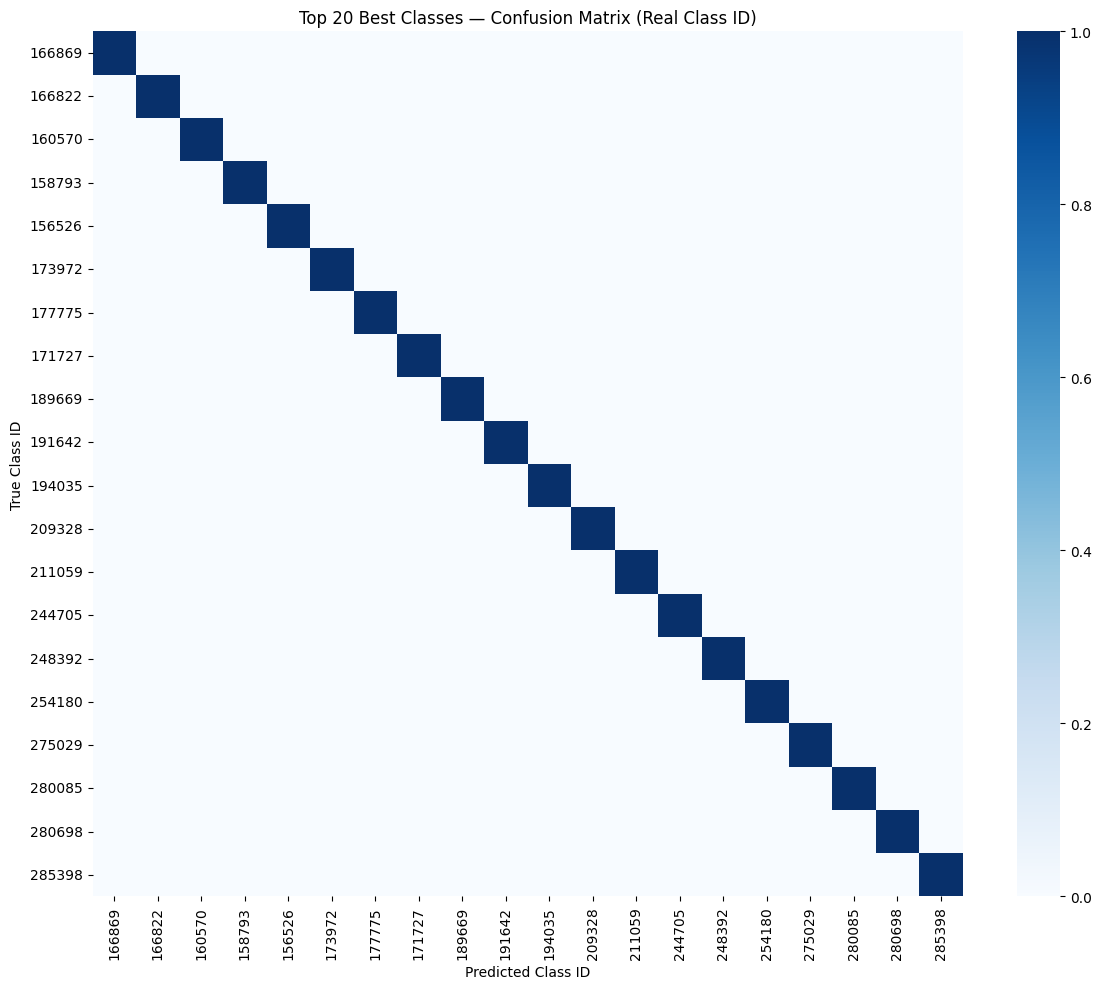

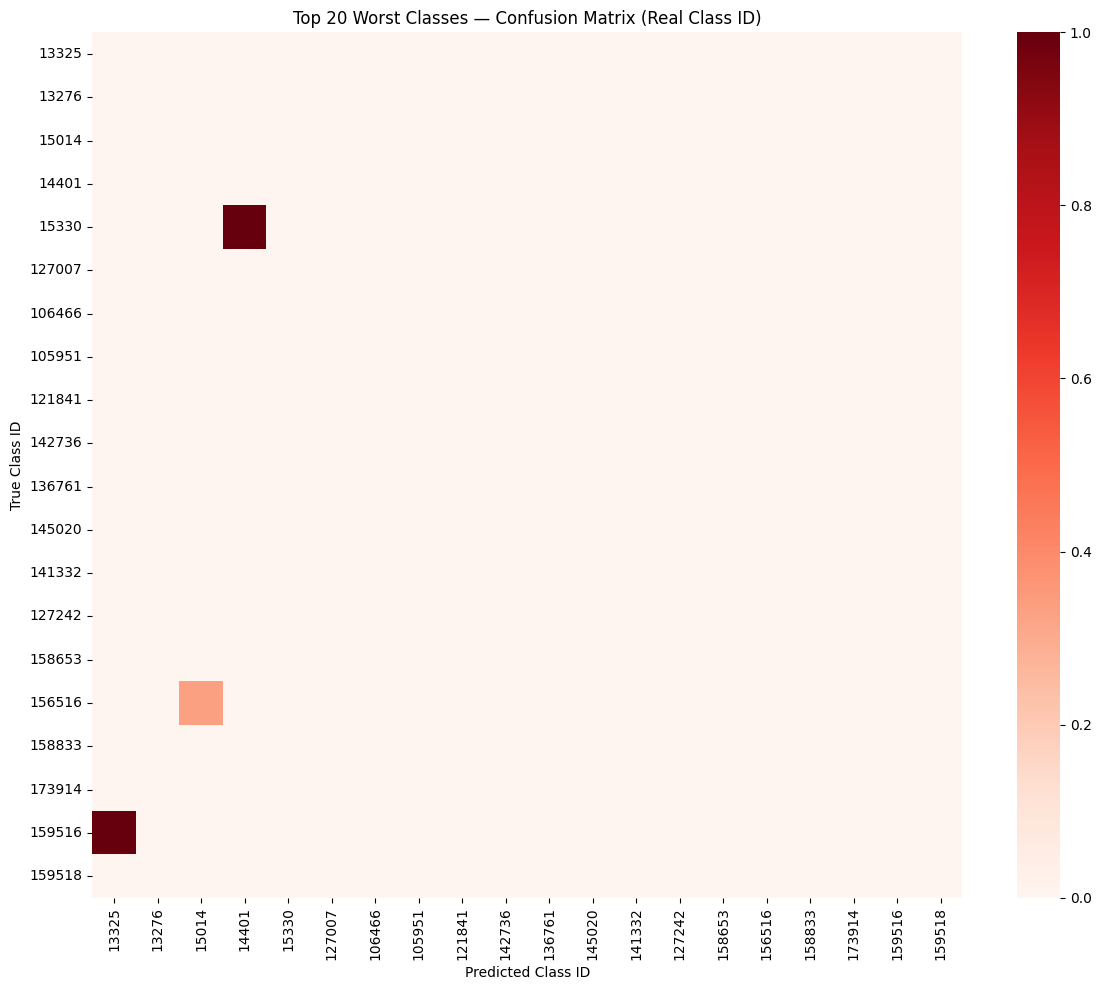

In [ ]:
# Step 1: Convert to real class IDs
idx_to_real = {v: k for k, v in label_to_idx.items()}
real_y_true = np.array([idx_to_real[i] for i in test_labels_arr])

# Step 2: Compute confusion matrix (normalized)
cm_real = confusion_matrix(real_y_true, real_y_pred, normalize='true')

# Step 3: Extract per-class accuracy (diagonal)
per_class_acc = np.diag(cm_real)

# Step 4: Sort classes
# argsort returns indices sorted by accuracy
sorted_idx = np.argsort(per_class_acc)

# Convert sorted indices (0..NUM_CLASSES-1) → real class IDs
real_class_ids_sorted = np.array([idx_to_real[i] for i in sorted_idx])

# Worst 20 (lowest accuracy)
worst20_real_ids = real_class_ids_sorted[:20]

# Best 20 (highest accuracy)
best20_real_ids = real_class_ids_sorted[-20:]

# Convert real IDs back to row/column indices in cm_real
# (Because cm_real rows/cols are still in the remapped order)
worst20_idx = [label_to_idx[x] for x in worst20_real_ids]
best20_idx  = [label_to_idx[x] for x in best20_real_ids]

# ---------------------------------------------------------
# Plot TOP 20 BEST classes
# ---------------------------------------------------------
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_real[np.ix_(best20_idx, best20_idx)],
    cmap="Blues",
    xticklabels=best20_real_ids,
    yticklabels=best20_real_ids,
    annot=False
)
plt.title("Top 20 Best Classes — Confusion Matrix (Real Class ID)")
plt.xlabel("Predicted Class ID")
plt.ylabel("True Class ID")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# Plot TOP 20 WORST classes
# ---------------------------------------------------------
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_real[np.ix_(worst20_idx, worst20_idx)],
    cmap="Reds",
    xticklabels=worst20_real_ids,
    yticklabels=worst20_real_ids,
    annot=False
)
plt.title("Top 20 Worst Classes — Confusion Matrix (Real Class ID)")
plt.xlabel("Predicted Class ID")
plt.ylabel("True Class ID")
plt.tight_layout()
plt.show()

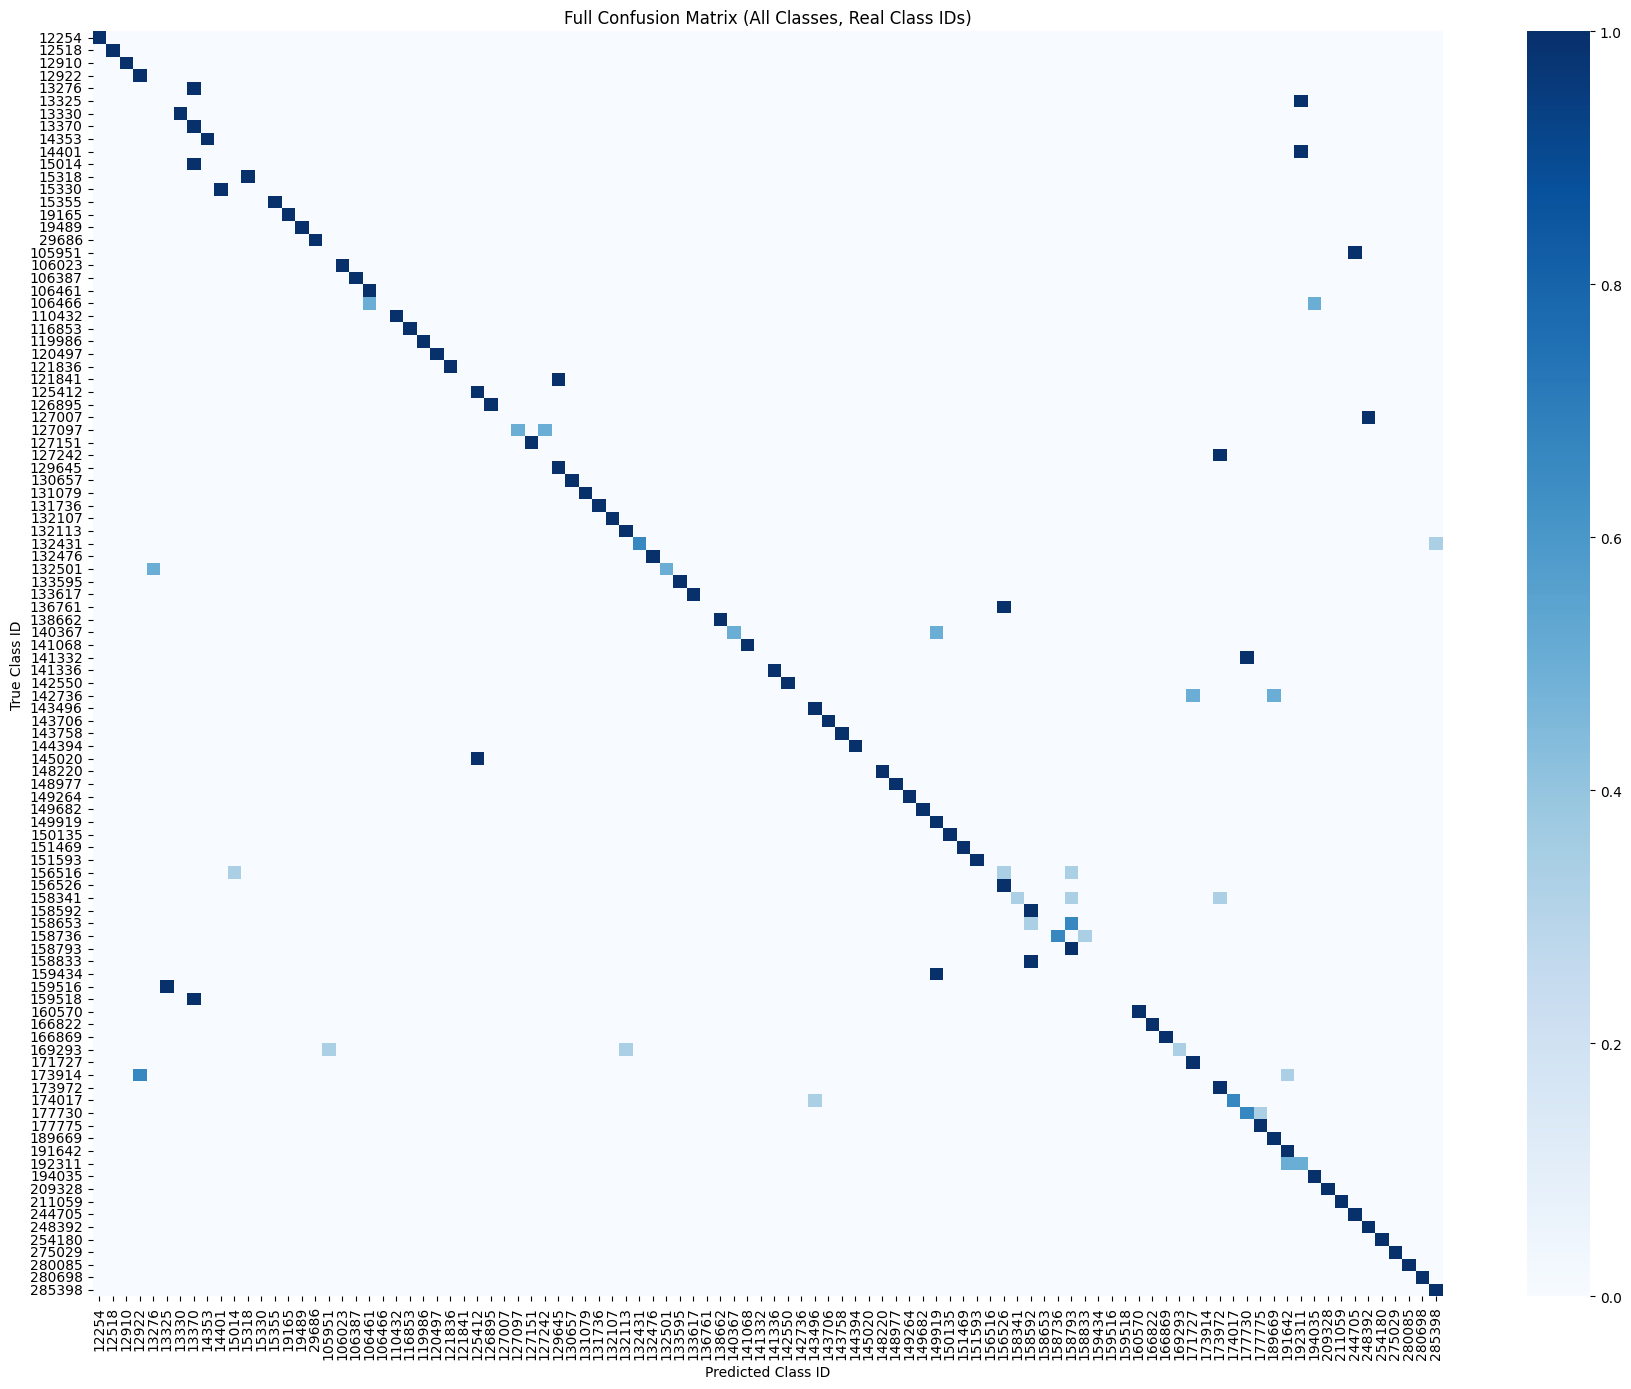

In [ ]:
# ============================================
# FULL CONFUSION MATRIX — ALL CLASSES
# ============================================

plt.figure(figsize=(18, 14))

sns.heatmap(
    cm_real,
    cmap="Blues",          # good for large matrices
    xticklabels=[idx_to_real[i] for i in range(NUM_CLASSES)],
    yticklabels=[idx_to_real[i] for i in range(NUM_CLASSES)],
    cbar=True
)

plt.title("Full Confusion Matrix (All Classes, Real Class IDs)")
plt.xlabel("Predicted Class ID")
plt.ylabel("True Class ID")
plt.tight_layout()
plt.show()